In [1]:
import os
import re
import pandas as pd
import numpy as np

In [3]:
multiple_seeds_exp_log_path = "/home/gsoykan/Desktop/dev/multilingual-adapters/data/paper_logs/main_results_exp_logs"

In [2]:
def parse_log(file_path):
    """
    Parses the log file for task results, both overall and by language.
    """
    results = {}
    with open(file_path, 'r') as file:
        content = file.readlines()

    content = content[-100:]
    capture = False
    for line in content:
        if line.strip().startswith('|'):
            if 'Tasks' in line or 'Groups' in line:
                capture = True
                continue
            if capture:
                line = line.strip()
                parts = [part.strip() for part in re.split(r'\|\s*', line) if part]
                if len(parts) >= 6:
                    task = parts[0].split()[0]

                    language = None
                    if len(parts[0].split()) > 1:
                        language = parts[0].split()[1]
                    metric = parts[4]
                    value = parts[5]

                    if '--' in value:
                        continue

                    stderr = parts[7] if len(parts) > 7 else None
                    if task not in results:
                        if '-' not in task:
                            results[task] = {}
                    if language:
                        # print(task, language)
                        task, language = language.split('_')
                        language = 'ja' if language == 'jp' else language
                        task = 'pawsx' if task == 'paws' else task
                        results[task][language] = {'metric': metric, 'value': value, 'stderr': stderr}
                    else:
                        results[task]['overall'] = {'metric': metric, 'value': value, 'stderr': stderr}
        else:
            capture = False
    return results

In [3]:
from collections import defaultdict


def process_directory(directory,
                      is_varying_size_exp: bool = False):
    formatted_res = defaultdict(dict)

    for filename in os.listdir(directory):
        if filename.endswith(".log"):
            filepath = os.path.join(directory, filename)
            # print(f"Processing file: {filename}")

            if is_varying_size_exp:
                model, rem = filename.split('_ls_')
                rem = rem[:-4]  # get rid of .log
                ls, _, num_lang, exp_number = rem.split('_')
                ls = num_lang  # little hack instead of subset name, use num. langs
            else:
                model, rem = filename.split('_ls_')
                rem = rem[:-4]
                ls, exp_number = rem.split('_')
                # print(model, ls, exp_number)

            if ls not in formatted_res[model]:
                formatted_res[model][ls] = {}

            formatted_res[model][ls][exp_number] = {}

            results = parse_log(filepath)
            for task, data in results.items():
                # print(f"Results for {task}:")
                formatted_res[model][ls][exp_number][task] = {}
                for lang, metrics in data.items():
                    # print(f"  {lang}: {metrics['value']}")
                    formatted_res[model][ls][exp_number][task][lang] = metrics['value']
            # print("\n")

    return formatted_res

In [5]:
results = process_directory(multiple_seeds_exp_log_path)

In [6]:
from pprint import pprint
import json

pprint(results)

defaultdict(<class 'dict'>,
            {'bloom1_7b': {'all': {'1': {'pawsx': {'de': '0.5180',
                                                   'en': '0.4765',
                                                   'es': '0.4675',
                                                   'fr': '0.5420',
                                                   'ja': '0.5600',
                                                   'ko': '0.5480',
                                                   'overall': '0.5198',
                                                   'zh': '0.5265'},
                                         'xcopa': {'et': '0.4740',
                                                   'ht': '0.5140',
                                                   'id': '0.6700',
                                                   'it': '0.5300',
                                                   'overall': '0.5624',
                                                   'qu': '0.5220',
                       

In [7]:
print(results['mgpt']['typo']['1'].keys())

dict_keys(['pawsx', 'xcopa', 'xnli', 'xstorycloze', 'xwinograd'])


In [8]:
print(results['mgpt']['typo']['1']['pawsx']['overall'])

0.5001


In [9]:
main_table_models = set(results.keys()) - {'bloom3b', 'bloom1_7b'}
print(main_table_models)

{'mt5', 'mgpt', 'bloom7b'}


In [10]:
main_table_subsets = set(results['mgpt'].keys()) - {'resource', 'vi'}
main_table_subsets

{'all', 'family', 'geo', 'learned', 'random', 'semantic', 'typo'}

In [4]:
def flatten_data(data,
                 filter_non_overall: bool = False, ):
    rows = []
    # Iterate over each model
    for model, domains in data.items():
        # Iterate over each domain like 'family', 'geo', etc.
        for domain, results in domains.items():
            # Iterate over each result set

            for result_set, tasks in results.items():
                # Iterate over each task

                set_avg = 0
                set_tasks = 0

                for task, languages in tasks.items():

                    # Iterate over each language and its score
                    for language, score in languages.items():

                        if language == 'overall':
                            set_avg += float(score) * 100
                            set_tasks += 1

                        if filter_non_overall:
                            if language != 'overall':
                                continue
                            rows.append({
                                'Model': model,
                                'Domain': domain,
                                'Result Set': result_set,
                                'Task': task,
                                'Score': float(score) * 100
                            })
                        else:
                            rows.append({
                                'Model': model,
                                'Domain': domain,
                                'Result Set': result_set,
                                'Task': task,
                                'Language': language,
                                'Score': float(score) * 100
                            })

                if filter_non_overall:
                    rows.append({
                        'Model': model,
                        'Domain': domain,
                        'Result Set': result_set,
                        'Task': 'SET AVG',
                        'Score': set_avg / set_tasks
                    })

    return pd.DataFrame(rows)

In [5]:
from scipy.stats import t


def calculate_stats(df, include_language: bool = False):
    if include_language:
        results = df.groupby(['Model', 'Domain', 'Task', 'Language']).agg(
            Mean=('Score', 'mean'),
            Std_Dev=('Score', 'std'),
            Count=('Score', 'count')
        )
    else:
        results = df.groupby(['Model', 'Domain', 'Task']).agg(
            Mean=('Score', 'mean'),
            Std_Dev=('Score', 'std'),
            Count=('Score', 'count')
        )

    # Calculate the standard error of the mean
    results['Std_Error'] = results['Std_Dev'] / np.sqrt(results['Count'])

    # Determine the critical t-value for 95% confidence
    critical_t = t.ppf(0.975, df=results['Count'] - 1)  # 0.975 because it's two-tailed for 95% confidence

    # Calculate the margin of error
    results['Margin_of_Error'] = critical_t * results['Std_Error']

    # Calculate the confidence intervals
    results['CI Lower'] = results['Mean'] - results['Margin_of_Error']
    results['CI Upper'] = results['Mean'] + results['Margin_of_Error']

    return results

In [13]:
df = flatten_data(results, filter_non_overall=True)
print(df)

       Model    Domain Result Set         Task   Score
0    bloom3b  semantic          3        pawsx  48.490
1    bloom3b  semantic          3        xcopa  56.650
2    bloom3b  semantic          3         xnli  40.720
3    bloom3b  semantic          3  xstorycloze  59.040
4    bloom3b  semantic          3    xwinograd  70.600
..       ...       ...        ...          ...     ...
625  bloom7b   learned          3        xcopa  57.980
626  bloom7b   learned          3         xnli  40.960
627  bloom7b   learned          3  xstorycloze  61.990
628  bloom7b   learned          3    xwinograd  74.170
629  bloom7b   learned          3      SET AVG  56.568

[630 rows x 5 columns]


In [14]:
df.to_csv('journal_exp_with_multi_seeds_results.csv')

In [19]:
df = flatten_data(results, filter_non_overall=False)
print(df)
df.to_csv('journal_exp_with_multi_seeds_results_non_overall.csv')

        Model    Domain Result Set       Task Language  Score
0     bloom3b  semantic          3      pawsx  overall  48.49
1     bloom3b  semantic          3      pawsx       de  44.85
2     bloom3b  semantic          3      pawsx       en  41.95
3     bloom3b  semantic          3      pawsx       es  42.40
4     bloom3b  semantic          3      pawsx       fr  53.75
...       ...       ...        ...        ...      ...    ...
5770  bloom7b   learned          3  xwinograd       fr  75.90
5771  bloom7b   learned          3  xwinograd       ja  61.94
5772  bloom7b   learned          3  xwinograd       pt  76.43
5773  bloom7b   learned          3  xwinograd       ru  54.92
5774  bloom7b   learned          3  xwinograd       zh  73.02

[5775 rows x 6 columns]


In [15]:
# Convert to DataFrame
df = flatten_data(results, filter_non_overall=True)
# Calculate statistics
stats_df = calculate_stats(df)

# Display results
print(stats_df)

                                   Mean   Std_Dev  Count  Std_Error  \
Model     Domain Task                                                 
bloom1_7b all    SET AVG      54.767333  0.067092      3   0.038736   
                 pawsx        51.786667  0.174738      3   0.100885   
                 xcopa        56.286667  0.080829      3   0.046667   
                 xnli         40.160000  0.144222      3   0.083267   
                 xstorycloze  58.250000  0.052915      3   0.030551   
...                                 ...       ...    ...        ...   
mt5       typo   pawsx        51.400000  0.138924      3   0.080208   
                 xcopa        53.216667  0.217332      3   0.125477   
                 xnli         36.623333  0.150444      3   0.086859   
                 xstorycloze  52.580000  0.138564      3   0.080000   
                 xwinograd    50.093333  0.346747      3   0.200194   

                              Margin_of_Error   CI Lower   CI Upper  
Model 

In [16]:
stats_df.to_csv('journal_exp_with_multi_seeds_stats_results.csv')

In [22]:
df = flatten_data(results, filter_non_overall=False)
stats_df = calculate_stats(df, include_language=True)

print(stats_df)
stats_df.to_csv('journal_exp_with_multi_seeds_stats_results_non_overall.csv')

                                          Mean   Std_Dev  Count  Std_Error  \
Model     Domain Task      Language                                          
bloom1_7b all    pawsx     de        51.500000  0.300000      3   0.173205   
                           en        47.566667  0.236291      3   0.136423   
                           es        46.200000  0.526783      3   0.304138   
                           fr        54.016667  0.160728      3   0.092796   
                           ja        55.916667  0.076376      3   0.044096   
...                                        ...       ...    ...        ...   
mt5       typo   xwinograd ja        49.843333  0.581922      3   0.335973   
                           overall   50.093333  0.346747      3   0.200194   
                           pt        49.683333  0.438786      3   0.253333   
                           ru        50.056667  0.733235      3   0.423333   
                           zh        50.396667  1.892679      3 

# RESULTS for GEO Varying Langs

In [15]:
geo_mgpt_exp_log_path = "/home/gsoykan/Desktop/dev/multilingual-adapters/data/paper_logs/geo_varying_langs/mgpt"
results = process_directory(geo_mgpt_exp_log_path,
                            is_varying_size_exp=True)
from pprint import pprint
import json

pprint(results)
df = flatten_data(results, filter_non_overall=True)
print(df)
# Convert to DataFrame
df = flatten_data(results, filter_non_overall=True)
# Calculate statistics
stats_df = calculate_stats(df)

# Display results
print(stats_df)
stats_df.to_csv('geo_varying_langs_mgpt_stats_results.csv')
df = flatten_data(results, filter_non_overall=False)
stats_df = calculate_stats(df, include_language=True)

print(stats_df)
stats_df.to_csv('geo_varying_langs_mgpt_stats_results_non_overall.csv')

                                      Mean   Std_Dev  Count  Std_Error  \
Model Domain Task      Language                                          
mgpt  1      pawsx     de        47.833333  0.340343      3   0.196497   
                       en        44.750000  0.217945      3   0.125831   
                       es        48.916667  0.175594      3   0.101379   
                       fr        54.850000  0.050000      3   0.028868   
                       ja        55.200000  0.217945      3   0.125831   
...                                    ...       ...    ...        ...   
      9      xwinograd ja        54.603333  0.538176      3   0.310716   
                       overall   60.793333  0.398037      3   0.229807   
                       pt        58.300000  0.883346      3   0.510000   
                       ru        57.356667  0.662143      3   0.382288   
                       zh        65.673333  1.195003      3   0.689936   

                                 Marg

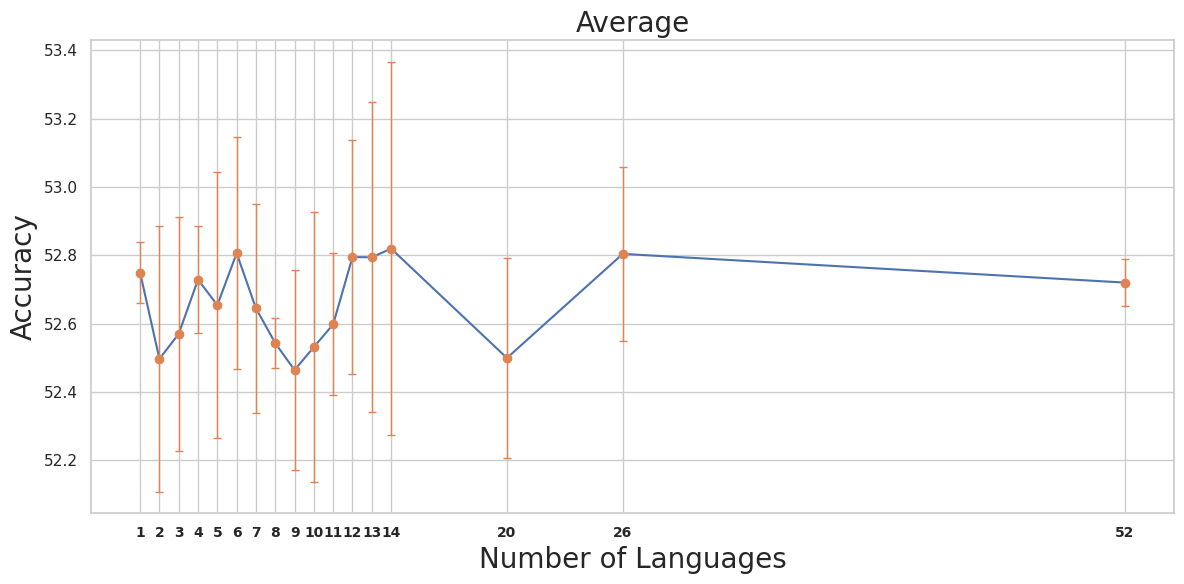

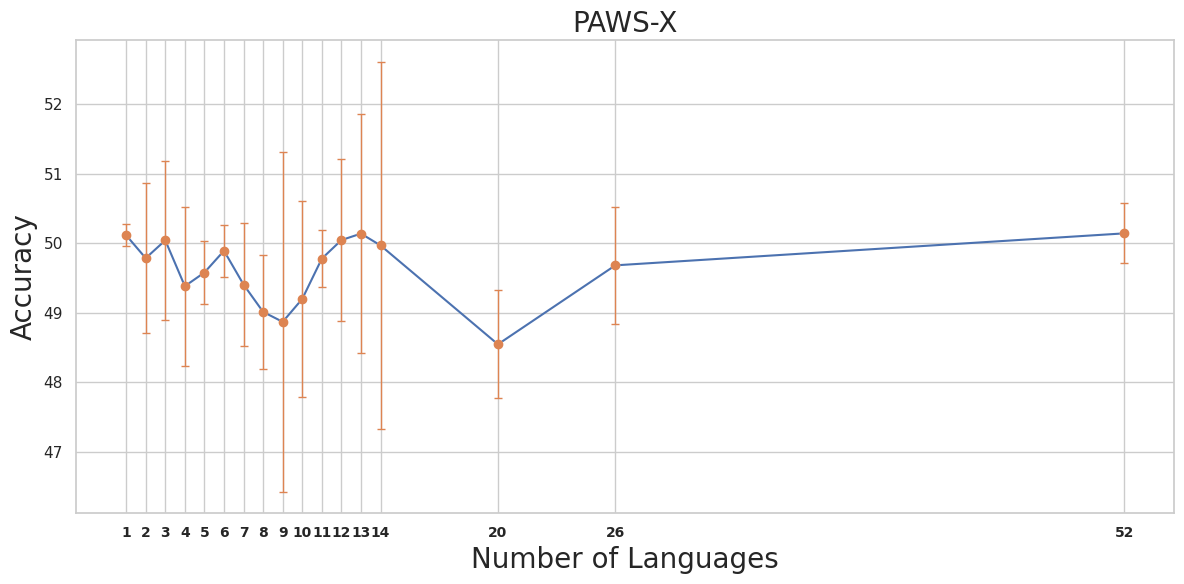

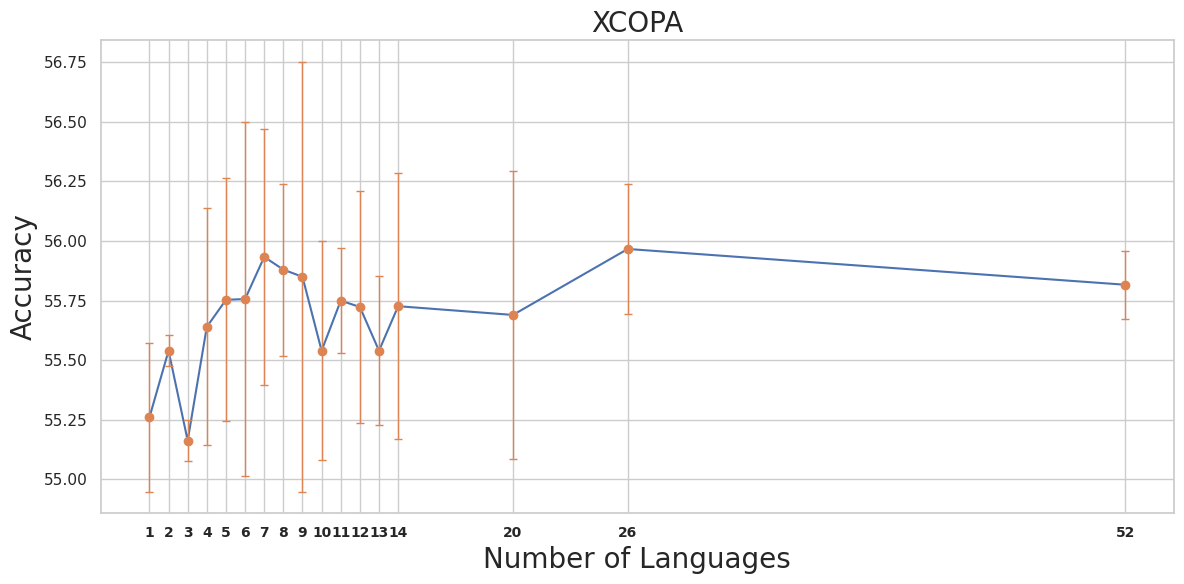

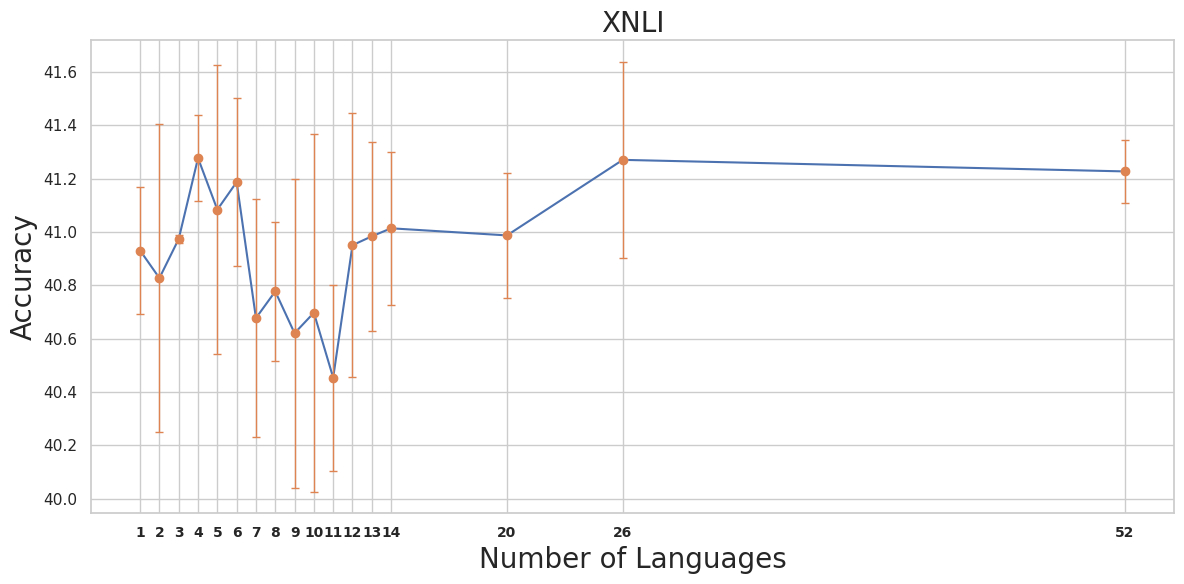

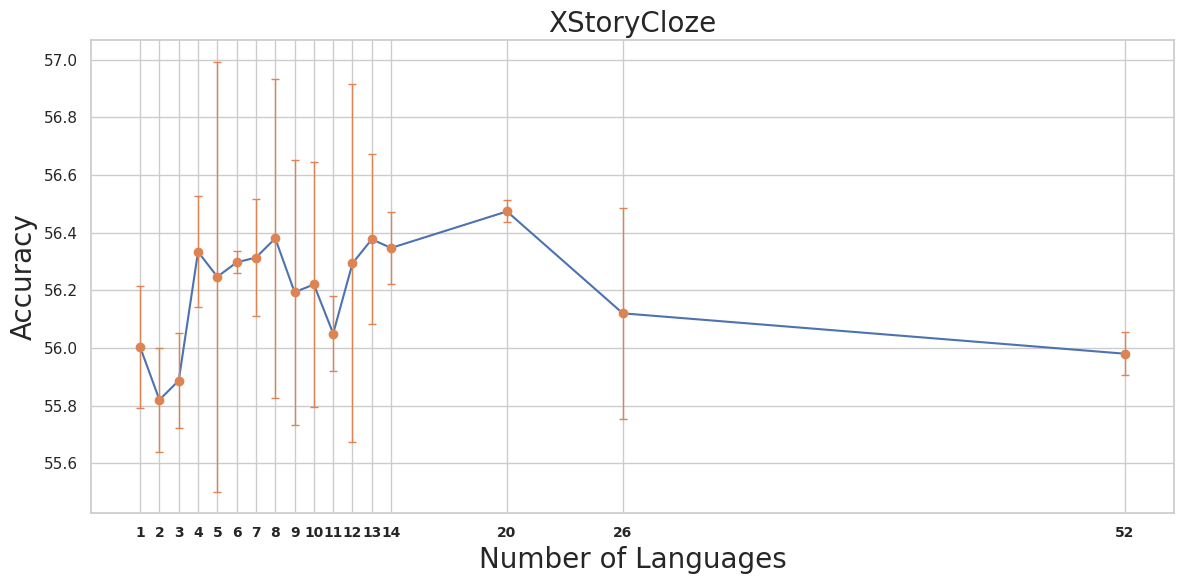

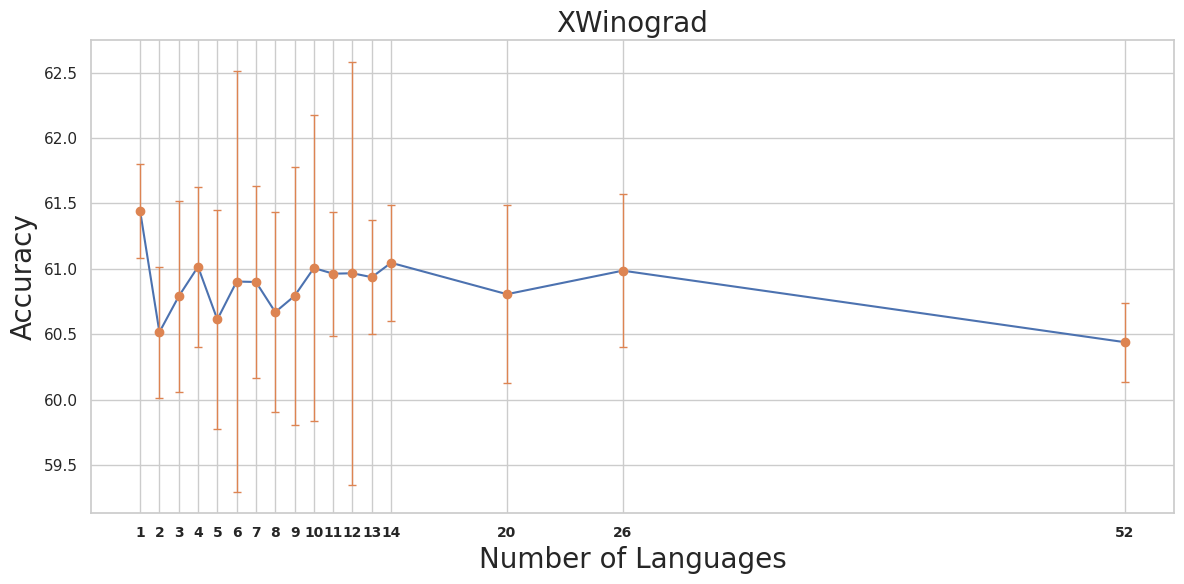

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/home/gsoykan/Desktop/dev/multilingual-adapters/src/notebooks/geo_varying_langs_mgpt_stats_results.csv'
data = pd.read_csv(file_path)

# Extract unique tasks
tasks = data['Task'].unique()

# Set seaborn style
sns.set(style="whitegrid")

# Plot for each task and task average with lines connecting means
for task in tasks:
    task_data = data[data['Task'] == task]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=task_data['Domain'],
                 y=task_data['Mean'],
                 marker='o',
                 label='')
    plt.errorbar(task_data['Domain'],
                 task_data['Mean'],
                 yerr=task_data['Margin_of_Error'],
                 fmt='o',
                 capsize=3,
                 elinewidth=1,
                 label='_nolegend_')

    if task == 'SET AVG':
        title = 'Average'
    elif task == 'pawsx':
        title = 'PAWS-X'
    elif task == 'xcopa':
        title = 'XCOPA'
    elif task == 'xnli':
        title = 'XNLI'
    elif task == 'xstorycloze':
        title = 'XStoryCloze'
    elif task == 'xwinograd':
        title = 'XWinograd'

    plt.title(title, fontsize=20)
    plt.xlabel('Number of Languages', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.xticks(task_data['Domain'], fontsize=10, fontweight='bold')
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'mgpt_geo_varying_langs_performance_{task}.png')
    plt.show()


#### Bloom7B results for Geo Varying Size

In [7]:
geo_bloom_exp_log_path = "/home/gsoykan/Desktop/dev/multilingual-adapters/data/paper_logs/geo_varying_langs/bloom7b"
results = process_directory(geo_bloom_exp_log_path,
                            is_varying_size_exp=True)
from pprint import pprint
import json

pprint(results)
df = flatten_data(results, filter_non_overall=True)
print(df)

defaultdict(<class 'dict'>,
            {'bloom7b': {'1': {'1': {'pawsx': {'de': '0.4700',
                                               'en': '0.3970',
                                               'es': '0.4330',
                                               'fr': '0.5320',
                                               'ja': '0.5405',
                                               'ko': '0.5415',
                                               'overall': '0.4871',
                                               'zh': '0.4960'},
                                     'xcopa': {'et': '0.4800',
                                               'ht': '0.5320',
                                               'id': '0.6940',
                                               'it': '0.5420',
                                               'overall': '0.5789',
                                               'qu': '0.5140',
                                               'sw': '0.5460',
                

In [8]:
# Convert to DataFrame
df = flatten_data(results, filter_non_overall=True)
# Calculate statistics
stats_df = calculate_stats(df)

# Display results
print(stats_df)
stats_df.to_csv('geo_varying_langs_bloom_stats_results.csv')

                                 Mean   Std_Dev  Count  Std_Error  \
Model   Domain Task                                                 
bloom7b 1      SET AVG      56.510667  0.116316      3   0.067155   
               pawsx        48.703333  0.150111      3   0.086667   
               xcopa        58.046667  0.146401      3   0.084525   
               xnli         40.760000  0.104403      3   0.060277   
               xstorycloze  60.766667  0.090738      3   0.052387   
...                               ...       ...    ...        ...   
        9      pawsx        47.110000  0.117898      3   0.068069   
               xcopa        58.030000  0.363731      3   0.210000   
               xnli         41.410000  0.111355      3   0.064291   
               xstorycloze  61.860000  0.010000      3   0.005774   
               xwinograd    74.333333  0.253246      3   0.146211   

                            Margin_of_Error   CI Lower   CI Upper  
Model   Domain Task               

In [9]:
df = flatten_data(results, filter_non_overall=False)
stats_df = calculate_stats(df, include_language=True)

print(stats_df)
stats_df.to_csv('geo_varying_langs_bloom_stats_results_non_overall.csv')

                                        Mean   Std_Dev  Count  Std_Error  \
Model   Domain Task      Language                                          
bloom7b 1      pawsx     de        48.300000  1.126943      3   0.650641   
                         en        39.733333  0.028868      3   0.016667   
                         es        43.266667  0.500833      3   0.289156   
                         fr        53.150000  0.050000      3   0.028868   
                         ja        53.650000  0.377492      3   0.217945   
...                                      ...       ...    ...        ...   
        9      xwinograd ja        61.453333  0.692122      3   0.399597   
                         overall   74.333333  0.253246      3   0.146211   
                         pt        76.046667  1.322132      3   0.763333   
                         ru        55.453333  0.184752      3   0.106667   
                         zh        73.746667  0.637207      3   0.367892   

           

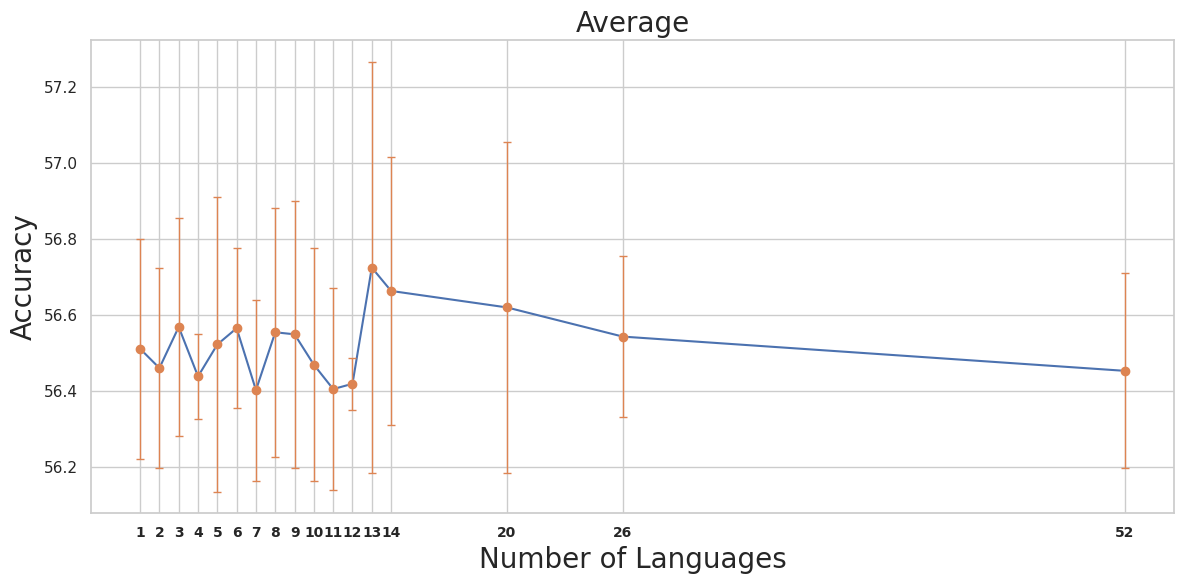

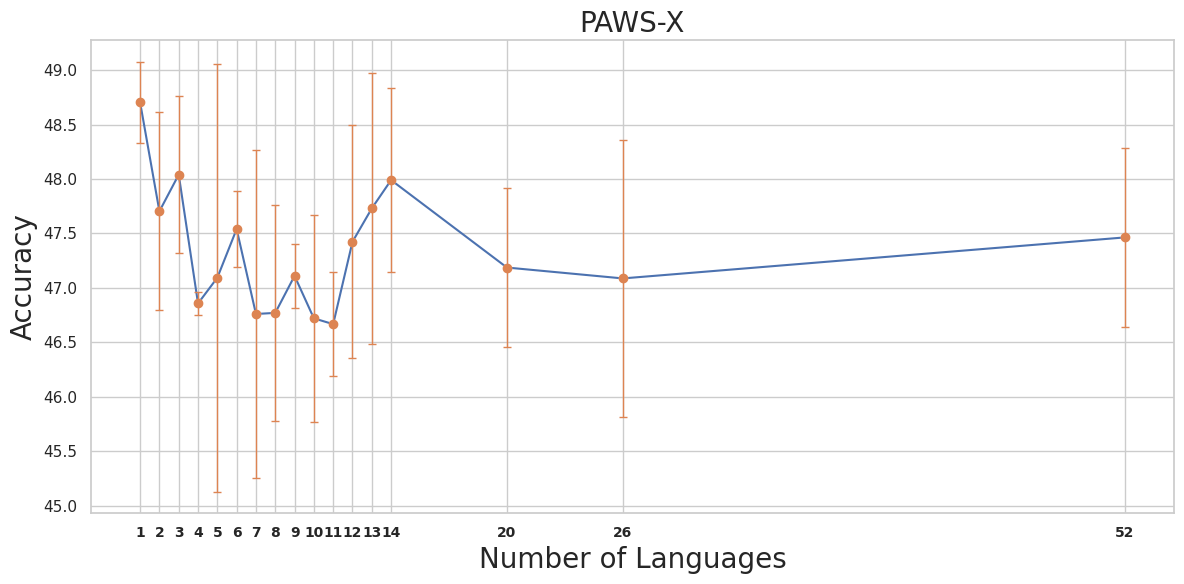

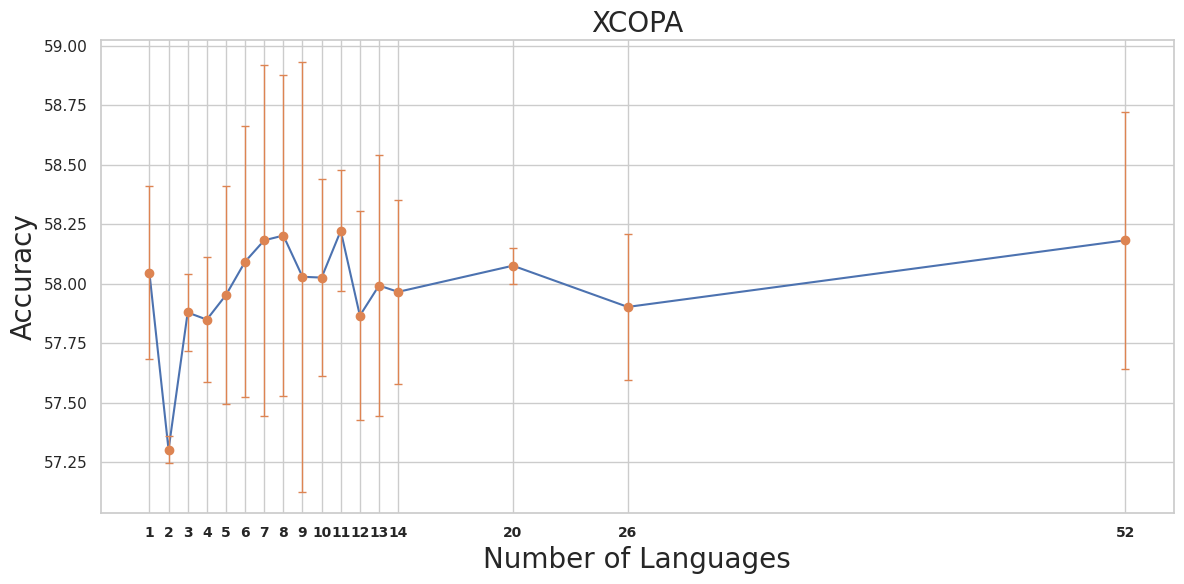

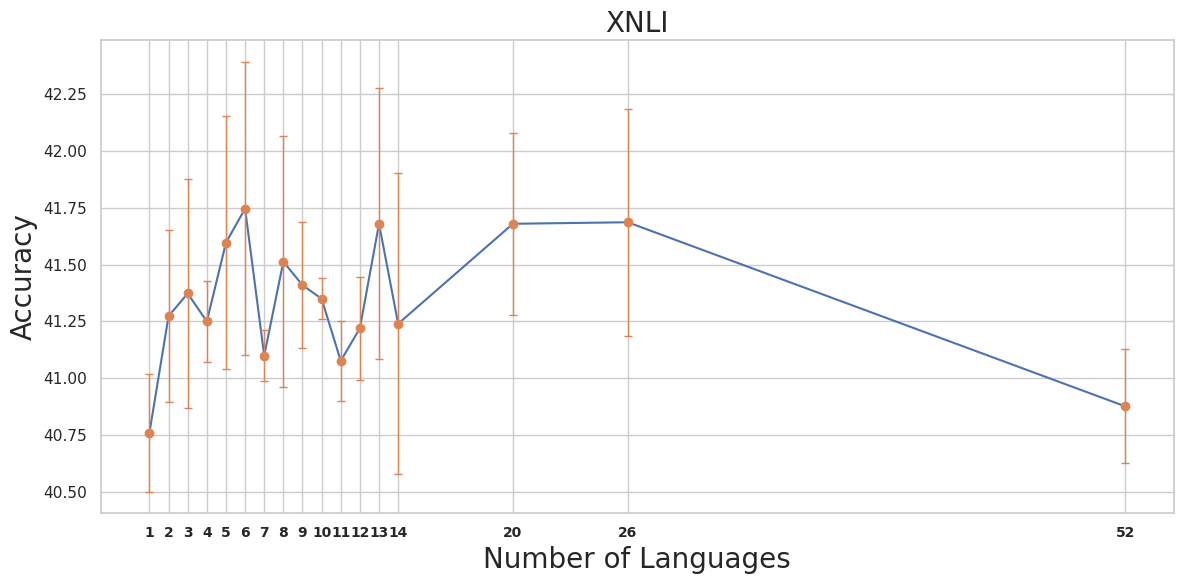

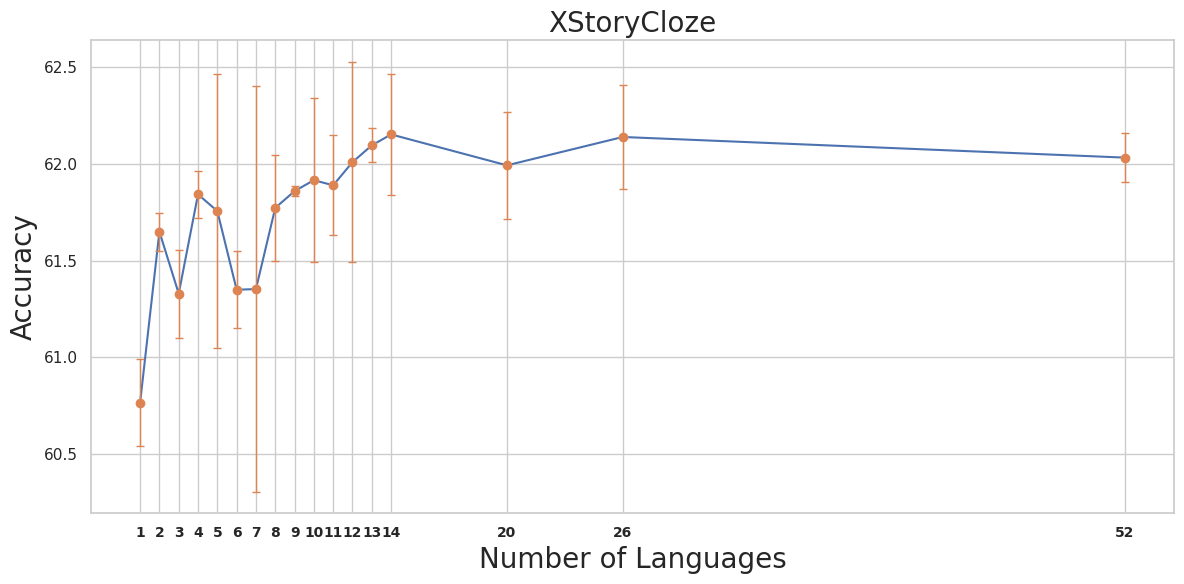

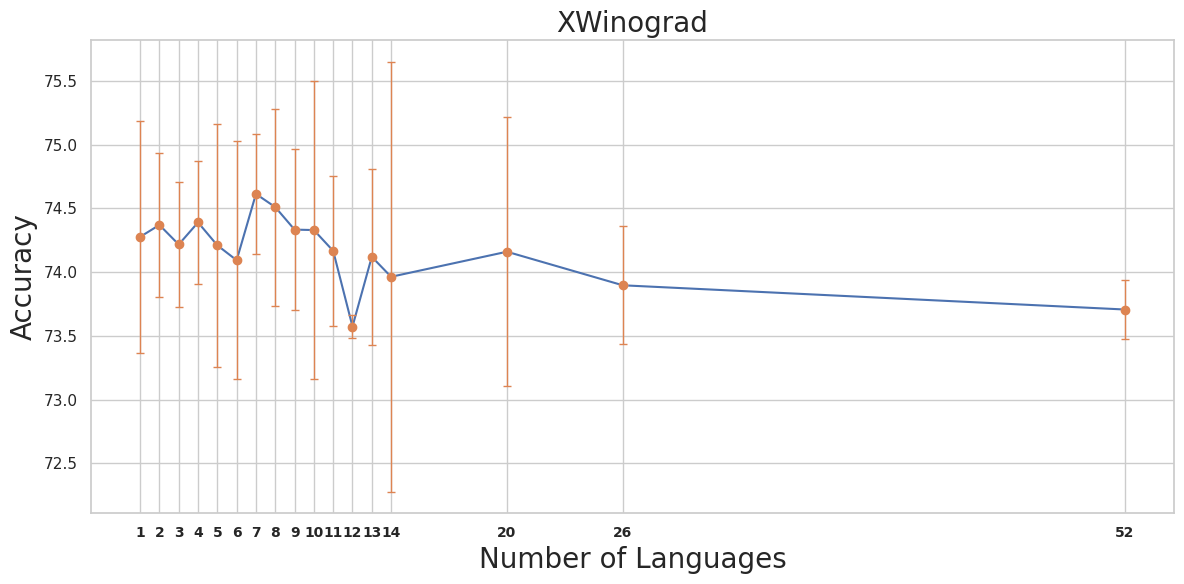

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/home/gsoykan/Desktop/dev/multilingual-adapters/src/notebooks/geo_varying_langs_bloom_stats_results.csv'
data = pd.read_csv(file_path)

# Extract unique tasks
tasks = data['Task'].unique()

# Set seaborn style
sns.set(style="whitegrid")

# Plot for each task and task average with lines connecting means
for task in tasks:
    task_data = data[data['Task'] == task]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=task_data['Domain'],
                 y=task_data['Mean'],
                 marker='o',
                 label='')
    plt.errorbar(task_data['Domain'],
                 task_data['Mean'],
                 yerr=task_data['Margin_of_Error'],
                 fmt='o',
                 capsize=3,
                 elinewidth=1,
                 label='_nolegend_')

    if task == 'SET AVG':
        title = 'Average'
    elif task == 'pawsx':
        title = 'PAWS-X'
    elif task == 'xcopa':
        title = 'XCOPA'
    elif task == 'xnli':
        title = 'XNLI'
    elif task == 'xstorycloze':
        title = 'XStoryCloze'
    elif task == 'xwinograd':
        title = 'XWinograd'

    plt.title(title, fontsize=20)
    plt.xlabel('Number of Languages', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.xticks(task_data['Domain'], fontsize=10, fontweight='bold')
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'bloom_geo_varying_langs_performance_{task}.png')
    plt.show()